
# Deep Neural Networks

## Session 10
### Neural Network with :

Changes for the Assignment

- **FIFA Dataset**
- One hidden layer
- ${Tanh}$ activation function
- **multi-class**
- ADAM
- Mini Batch
- L2 regularization
- ${Swish}$ Activation function

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [3]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from collections.abc import Callable
from typing import Literal

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [4]:
###----------------
### Some parameters
###----------------

inpDir = '../input'
outDir = '../output'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 2000 # number of epochs
ALPHA = 0.01 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2
BATCH_SIZE = 32
TRAIN_SIZE = 14496

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

## Helper Functions

In [5]:
###-----------------------------------
### Function to plot Decision boundary
###-----------------------------------

def fn_plot_decision_boundary(pred_func: Callable[[], np.float64], X_tr: np.ndarray, y_tr: np.ndarray, X_ts :  np.ndarray, y_ts:  np.ndarray,):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X_tr : train feature matrix
           y_tr : train labels
           X_ts : test feature matrix
           y_ts : test labels
       Return:
           None
    '''

    # Set min and max values and give it some padding
    xMin, xMax = X_tr[:, 0].min() - .05, X_tr[:, 0].max() + .05
    yMin, yMax = X_tr[:, 1].min() - .05, X_tr[:, 1].max() + .05

    # grid size for mesh grid
    h = 0.01

    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))

    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])

    # Make its shape same as that of xx
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    ax = fig.add_axes(111)

    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP) #, alpha = 0.8

    # Plotting scatter for train data
    ax.scatter(X_tr[:, 0], X_tr[:, 1],
               c=np.argmax(y_tr, axis = 1), # y_tr has two columns
               s=30, edgecolor='k', cmap=plt.cm.coolwarm)


    # Plotting scatter for test data
    ax.scatter(X_ts[:, 0], X_ts[:, 1],
               c=np.argmax(y_ts, axis = 1), # y_tr has two columns ,
                                  s=150, marker = '*',edgecolor='k', cmap=plt.cm.inferno )


## Generate Data Set
<p style="font-family: Arial; font-size:1em;">
Use Sklearn's dataset generator <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a>.
</p>

In [6]:
data_df=pd.read_csv('fifa_2019.csv')

In [7]:
data_df

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,18202,238813,J. Lundstram,19,https://cdn.sofifa.org/players/4/19/238813.png,England,https://cdn.sofifa.org/flags/14.png,47,65,Crewe Alexandra,...,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,€143K
18203,18203,243165,N. Christoffersson,19,https://cdn.sofifa.org/players/4/19/243165.png,Sweden,https://cdn.sofifa.org/flags/46.png,47,63,Trelleborgs FF,...,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,€113K
18204,18204,241638,B. Worman,16,https://cdn.sofifa.org/players/4/19/241638.png,England,https://cdn.sofifa.org/flags/14.png,47,67,Cambridge United,...,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0,€165K
18205,18205,246268,D. Walker-Rice,17,https://cdn.sofifa.org/players/4/19/246268.png,England,https://cdn.sofifa.org/flags/14.png,47,66,Tranmere Rovers,...,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0,€143K


In [8]:
for col in data_df.columns:
    print (f'{col} : {data_df[col].unique()}')

Unnamed: 0 : [    0     1     2 ... 18204 18205 18206]
ID : [158023  20801 190871 ... 241638 246268 246269]
Name : ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']
Age : [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]
Photo : ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']
Nationality : ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'Greece' 'Chile' 'Sweden' 'Korea Republic' 'Finland' 'Guinea'
 'Montenegro' 'Armenia' '

In [9]:
data_df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [10]:
data_df.isnull().sum()

Unnamed: 0           0
ID                   0
Name                 0
Age                  0
Photo                0
                  ... 
GKHandling          48
GKKicking           48
GKPositioning       48
GKReflexes          48
Release Clause    1564
Length: 89, dtype: int64

In [11]:
data_df = data_df[data_df['Position'].notnull()]
data_df.shape

(18147, 89)

In [12]:
rel_columns = ['Position', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes',]

"""['Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
          'Release Clause'],
      dtype='object']"""

"['Name', 'Age', 'Photo', 'Nationality', 'Flag',\n       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',\n       'Preferred Foot', 'International Reputation', 'Weak Foot',\n       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', \n       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',\n       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',\n       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',\n       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',\n          'Release Clause'],\n      dtype='object']"

In [13]:
data_df = data_df[rel_columns]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [14]:
data_df.isna().sum()

Position           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
GKDiving           0
GKHandling         0
GKKicking          0
GKPositioning      0
GKReflexes         0
dtype: int64

In [15]:
data_df.Position.unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

In [16]:
goalkeeper = 'GK'

forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS', 'LS', 'CF']

midfielders = ['CM', 'RCM', 'LCM', 'CDM', 'RDM', 'LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']

defence = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [17]:
data_df.loc[data_df['Position'] == 'GK', 'Position'] = 0

data_df.loc[data_df['Position'].isin(defence) ,     'Position'] = 1

data_df.loc[data_df['Position'].isin(midfielders) , 'Position'] = 2

data_df.loc[data_df['Position'].isin(forward) ,     'Position'] = 3

data_df['Position'] = pd.to_numeric(data_df['Position'], downcast='integer')

In [18]:
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [19]:
data_df['Position'].unique()

array([3, 0, 2, 1], dtype=int8)

In [20]:
labels = { 0 : 'Goal Keepers', 1 : 'Defence', 2 : 'Mid-fielders', 3 : 'Forward'}

In [21]:
features_df = data_df.drop('Position', axis= 1) # drop label col

label_df  = data_df['Position'] #labels

features_df.shape, label_df.shape

((18147, 33), (18147,))

In [22]:
features_df

,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,...,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0
18203,52.0,52.0,43.0,36.0,39.0,32.0,20.0,25.0,40.0,41.0,...,43.0,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0
18204,40.0,46.0,38.0,38.0,45.0,38.0,27.0,28.0,44.0,70.0,...,55.0,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0
18205,50.0,39.0,42.0,40.0,51.0,34.0,32.0,32.0,52.0,61.0,...,50.0,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0


In [23]:
# label_df = pd.get_dummies(label_df)
# label_df.shape

In [24]:
label_df.head()

0    3
1    3
2    3
3    0
4    2
Name: Position, dtype: int8

In [25]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(features_df, label_df,
                                                    #test_size=TEST_SIZE,
                                                    train_size= TRAIN_SIZE,
                                                    random_state=RANDOM_STATE,
                                                   stratify=label_df)

# print (train_X.shape, test_X.shape, test_y.shape, train_y.shape)

In [26]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train) #train
X_test = scaler.transform(X_test) #test


y_train = y_train.to_numpy() # array
y_test = y_test.to_numpy()  #convert to array

In [27]:
y_train

array([0, 2, 2, ..., 0, 0, 0], dtype=int8)

## Prepare Model:

In [28]:
knl_reg = tf.keras.regularizers.L2(l2=0.001)
dor1 = 0.05

model = tf.keras.Sequential([
    tf.keras.layers.Dense(18,kernel_regularizer=knl_reg),
    tf.keras.layers.BatchNormalization(),  # always put Before Dropout
    tf.keras.layers.Activation('relu'),    # Put Activation layer here after Normalsation
    tf.keras.layers.Dropout(rate = dor1,seed = RANDOM_STATE),
    tf.keras.layers.Dense(4)
])

**Note** - May also use below code for Activation function in Tensorflow Layer

```
tf.keras.layers.ReLU(),
tf.nn.relu(),

```

In [29]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [30]:
X_train[:1].shape

(1, 33)

In [31]:
predict = model(X_train[:1])
print(predict)

tf.Tensor([[-0.01669556  1.6481283   2.6496527   1.5028322 ]], shape=(1, 4), dtype=float32)


In [32]:
predict.numpy().sum()

5.7839174

In [33]:
tf.nn.softmax(predict).numpy().sum()

0.99999994

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 18)                   612       
                                                                 
 batch_normalization (Batch  (1, 18)                   72        
 Normalization)                                                  
                                                                 
 activation (Activation)     (1, 18)                   0         
                                                                 
 dropout (Dropout)           (1, 18)                   0         
                                                                 
 dense_1 (Dense)             (1, 4)                    76        
                                                                 
Total params: 760 (2.97 KB)
Trainable params: 724 (2.83 KB)
Non-trainable params: 36 (144.00 Byte)
_______________________

In [35]:
predict_model = model
predict_model.add(tf.keras.layers.Softmax(axis =1))
predict_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 18)                   612       
                                                                 
 batch_normalization (Batch  (1, 18)                   72        
 Normalization)                                                  
                                                                 
 activation (Activation)     (1, 18)                   0         
                                                                 
 dropout (Dropout)           (1, 18)                   0         
                                                                 
 dense_1 (Dense)             (1, 4)                    76        
                                                                 
 softmax (Softmax)           (1, 4)                    0         
                                                        

In [36]:
model.compile(optimizer='adam',loss = loss_function,metrics=['accuracy'])

In [37]:
history = model.fit(X_train,y_train,
                    validation_data = [X_test,y_test],
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    verbose = 0
                   )

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


In [39]:
loss_df = pd.DataFrame(history.history)

In [40]:
loss_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.630016,0.761658,0.411011,0.835661
1,0.400754,0.842922,0.354122,0.849082
2,0.372099,0.853615,0.340797,0.858121
3,0.359597,0.857823,0.330315,0.864695
4,0.347586,0.859272,0.321510,0.869077


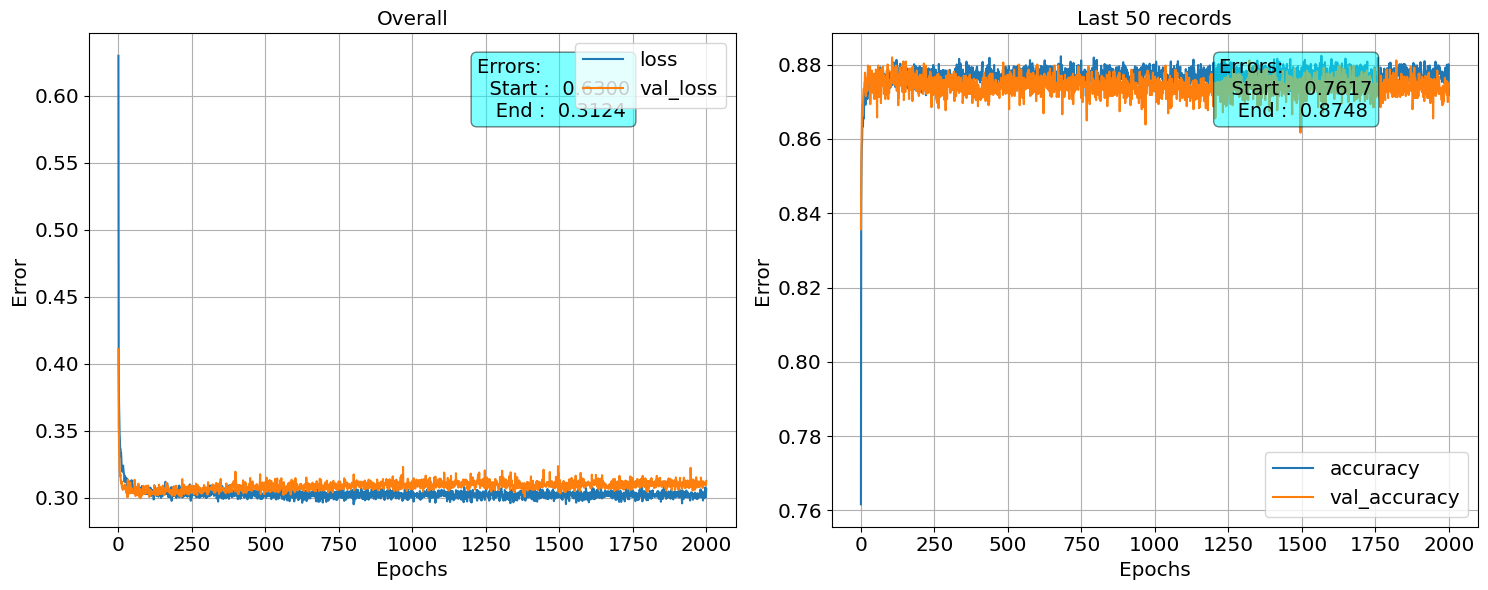

In [43]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 50

ax = axes[0]


ax = axes[0]
y1 = loss_df.columns[0]
y2 = loss_df.columns[2]

loss_df.plot(y = [y1,y2], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[0][y1],
                                                                loss_df.iloc[-1][y2]) #text to plot

# properties  matplotlib.patch.Patch
props = dict(boxstyle='round', facecolor='aqua', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')
ax.grid();


y1 = loss_df.columns[1]
y2 = loss_df.columns[3]

ax = axes[1]

loss_df.plot(y = [y1,y2], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[0][y1],
                                                                loss_df.iloc[-1][y2]) #text to plot

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))
ax.grid();
plt.tight_layout()

In [ ]:
loss_df[loss_df['t_loss'] == (loss_df['t_loss'].min())]

## Predictions
### Train Data

In [ ]:
# def fn_m
# ake_predicitions(pred_func, X_train):
#     y_pred = pred_func(X)
#     return y_pred

In [ ]:
y_pred = predict(model, X_train)
print('Accuracy score on Train Data :', accuracy_score(np.argmax(y_train, axis =1), y_pred))

In [ ]:
print(classification_report(np.argmax(y_train, axis =1), y_pred))

### Test Data

In [ ]:
y_pred = predict(model,X_test)

print('Accuracy score on Test Data :', accuracy_score(np.argmax(y_test, axis = 1), y_pred))

In [ ]:
print(classification_report(np.argmax(y_test, axis = 1), y_pred))

In [ ]:
## Confusion Matrix helps

cm  = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)
cm

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              #display_labels=labels.values()
                             )

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False)

plt.show();